# Hands-on Perception: Learning Event-based Data and Motion Compensation
## Event-based Cameras
Event-based Cameras (EBCs) are imaging sensors that respond to local brightness changes. Unlike conventional frame-based cameras, EBCs are asynchronous, having each pixel operating independently from the other. Each pixel reports a change of intensity (if it occurs), or stays silent otherwise. For example, a pixel stores a reference intensity at time $t$, the current intensity is then compared to the reference at time $t + 1$. If the aforementioned difference exceeds the threshold, that pixel outputs an **event**.

An **event** is a discrete packet of information containing:
* Event location ($x$ and $y$ coordinates, across the height and width dimensions respectively).
* Event timestamps $t$, the time at which the event occurred.
* Event polarity $p$, the direction of intensity change. It does not contain any information regarding intensity values. It is an output spike that can either be $+1$, or $-1$.

## Data Structure
### Dataset
For the sake of this lab, we will be using the **MVSEC** dataset. The MVSEC dataset is designed for the development of novel 3D perception algorithms for EBCs. In fact, stereo event-based data is collected from cars, motorbikes, hexa-copters and handhelds, fused with LiDAR, IMU, motion-capture and GPS systems to provide ground truth pose and depth images.

> **Note:**
> You can read more about the "MVSEC" dataset [here](https://daniilidis-group.github.io/mvsec/). Before starting this lab, it is important to understand the data structure of MVSEC. This dataset has been taken with a **DAVIS346B** sensor of resolution **(260, 346)**.

## eWiz
To load and manipulate the dataset, we will be using our own **eWiz** library for event-based data reading and manipulation. The **eWiz** library contains a series of modules, which include, but is not limited to:
* **Data Reading:** Reads and clips event-based and ground truth flow optical flow data, which use the eWiz format.
* **Data Rendering:** Renders event-based sequences.
* **Data Augmentations:** Applies temporal and spatial augmentations to event-based data and corresponding grayscale images.
* **Accuracy Metrics:** Provides several accuracy metrics for optical flow evaluation, such as the *Average Endpoint Error (AEE)*, and the percentage of outliers.
* **Visualizations:** Provides visualization functions for optical flow, event-based data, and grayscale images.

### Installation
First, install eWiz by following the steps on the official repository [here](https://github.com/CIRS-Girona/ewiz).
You can check the official [documentation](https://ewiz.readthedocs.io) to see how to use the functions in this lab (API References section). Also, download the *Indoor Flying 1* dataset of MVSEC in the eWiz format [here](https://drive.google.com/drive/folders/1orzPdKZk1NNHhkuW2iA3bTpb11d5JSzg?usp=sharing).

## **Part 1:** Data Loading
In this part, you will be looking at the full sequence of one of the datasets. Your tasks are:
1. Choose the dataset, and render it using the `VideoRendererBase` class.
2. Choose a sequence of *0.2 s*, in which you observe a clear movement in one direction. Specify in your answer the chosen timestamps.
3. Extract that sequence using the data reader of eWiz, and print the extracted events.


### Data Renderer
Write the data renderer code in the code block below.

In [ ]:
from ewiz.renderers.videos import VideoRendererBase

# ===== Run video renderer here ===== #
# Do not forget to look at the documentation to understand how to run the renderer
renderer = VideoRendererBase(data_dir="", data_range=None)
renderer.play()

### Data Reading
Clip the sequence in the code block below.

In [ ]:
from ewiz.data.readers import ReaderFlow

# ===== Clip data here ===== #
# Do not forget to look at the documentation to understand how to run the renderer
reader = ReaderFlow(
    data_dir="/home/jad/Documents/datasets/mvsec/ewiz/indoor_flying1", clip_mode="time"
)
events, _, _, _ = reader[20000:21000]

In [ ]:
from ewiz.renderers.videos import VideoRendererBase

# ===== Video renderer check ===== #
# Double-check if this is the sequence you want with the video renderer
renderer = VideoRendererBase(data_dir="", data_range=None)
renderer.play()

### Questions
1. What could cause an event to have a positive or negative polarity?
2. Given the timestamp resolution, calculate the maximum theoretical event rate this sensor can handle. How would this impact applications like high-speed object tracking? Show explanation.
3. Event-based sensors can produce noise events (false positives) due to thermal noise or flickering light sources. Based on the initial event samples, how could you identify and filter out noise without significantly impacting true events? Explain.

## **[Answer Here]**

## **Part 2:** Data Manipulation
Event-based data is **asynchronous**, meaning that unlike intensity frame-based cameras, EBCs do not output data at a fixed frequency. This might be a problem for traditional neural network architectures (or computer vision algorithms) as they require data given synchronously. Moreover, EBCs are considered a paradigm shift as they do not output traditional images. As such, if we want to work with convolutional neural networks (CNNs) this event-based data (the array you printed previously) should be converted to an **image-like** equivalent. This is what we call events-to-image encoding, which converts event-based data to a traditional image (either grayscale, RGB, or 2-channels).

For the sake of this lab, let's start by creating a simple events image. Using the **events** data you printed earlier, we want to insert each event in its respective pixel location, for which each channel corresponds to a different polarity. As such, the output image will have the shape **(C, H, W)**, where:
* **C:** The channel dimension (its value is 2), the first element encapsulates **positive** polarities, whereas the second element encapsulates **negative** polarities.
* **H:** The **height** dimension, which corresponds to the y-dimension of the sensor.
* **W:** The **width** dimension, which corresponds to the x-dimension of the sensor.

> **Note:** Each pixel value should correspond to the number of events that took place at that pixel location (sum of events, or **count** method).

Your job is to:
* Convert extracted events to an image representation, fill the `convert_events_to_image` function.
* Use the provided visualization functions to visualize the images:
    * A **heatmap** representation of the combined channels, printing the pixel value with the highest number of events.
    * An RGB image showing **positive alone**, **negative alone**, and **combined** events representation.

Combined heatmap is shown below:


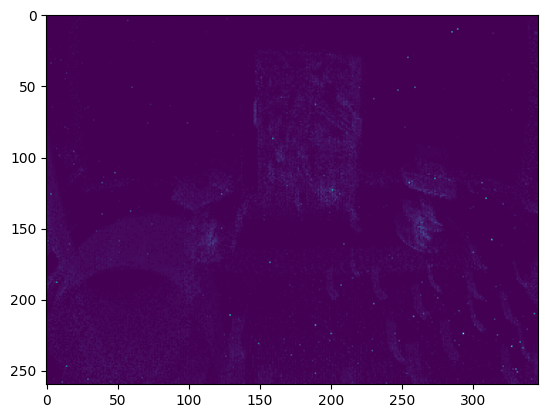

Maximum number of events is: 101
Positive 'RGB' image is shown below:


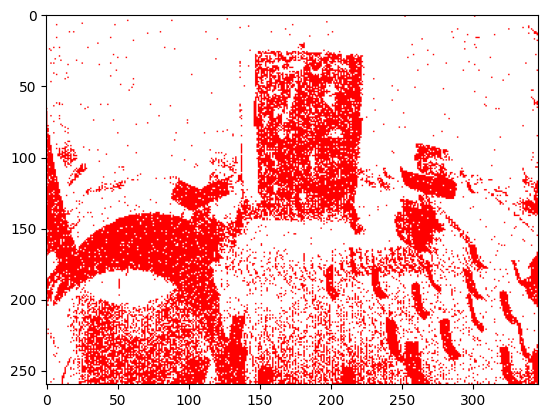

Negative 'RGB' image is shown below:


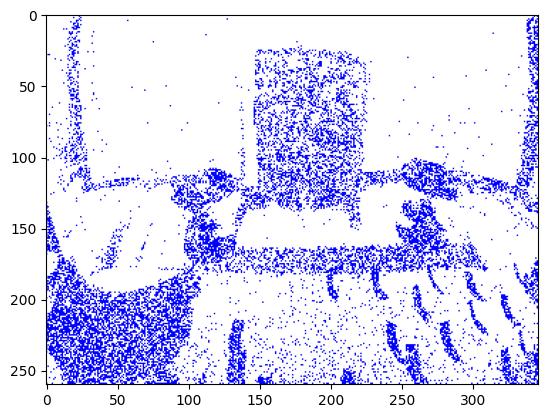

Combined 'RGB' image is shown below:


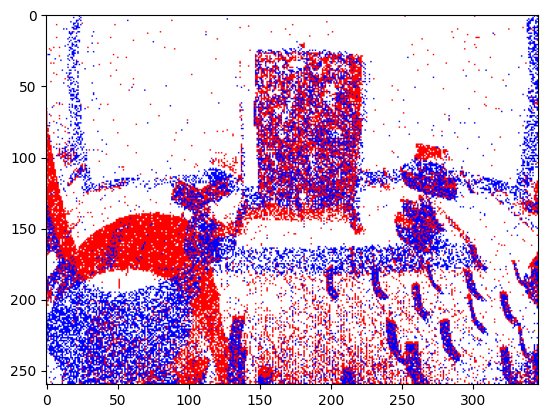

In [8]:
import numpy as np
import matplotlib.pyplot as plt

from typing import Tuple


# ===== Code inside function ===== #
def convert_events_to_image(
    events: np.ndarray, image_size: Tuple[int, int]
) -> np.ndarray:
    """
    Converts a sequence of events to a 2-channel events image.

    Args:
        events (np.ndarray): Events array, returned by the data reader.
        image_size (Tuple[int, int]): The size of the output image, equal to
            the size of the sensor of format (H, W).

    Returns:
        events_image (np.ndarray): Output image of shape (2, H, W). Each pixel
            should contain an integer with the number of events that occurred at that location.
    """
    pos_events = events[events[:, 3] > 0]
    neg_events = events[events[:, 3] == 0]
    # Positive coordinates
    pos_xs = pos_events[:, 0].astype(np.int32)
    pos_ys = pos_events[:, 1].astype(np.int32)
    # Negative coordinates
    neg_xs = neg_events[:, 0].astype(np.int32)
    neg_ys = neg_events[:, 1].astype(np.int32)
    # Initialize events image
    events_image = np.zeros(((2,) + image_size))
    # Create events image
    np.add.at(events_image[0, ...], (pos_ys, pos_xs), 1)
    np.add.at(events_image[1, ...], (neg_ys, neg_xs), 1)
    return events_image.astype(np.uint8)


# ================================ #


def visualize_events_heatmap(
    events_image: np.ndarray, polarity: str = "pos"
) -> np.ndarray:
    """
    Visualizes events heatmap based on the pixel-wise count of events.

    Args:
        events_image (np.ndarray): Generated events image.
        polarity (str): Polarity channel to show, can either be "pos", "neg", "both". Defaults to "pos".

    Returns:
        image (np.ndarray): Output image of shape (H, W).
    """
    if polarity == "pos":
        image = events_image[0, ...]
    elif polarity == "neg":
        image = events_image[1, ...]
    else:
        image = np.sum(events_image, axis=0)
    plt.imshow(image)
    plt.show()
    return image


def visualize_events_image_rgb(
    events_image: np.ndarray, polarity: str = "pos"
) -> np.ndarray:
    """
    Visualizes events heatmap based on the pixel-wise count of events.

    Args:
        events_image (np.ndarray): Generated events image.
        polarity (str): Polarity channel to show, can either be "pos", "neg", "both". Defaults to "pos".

    Returns:
        image (np.ndarray): Output image of shape (H, W, 3).
    """
    image_size = (events_image.shape[1], events_image.shape[2])
    image = np.zeros(((3,) + image_size), dtype=np.uint8) + 255
    if polarity == "pos":
        pos_ids = np.where(events_image[0, ...] > 0)
        image[:, pos_ids[0], pos_ids[1]] = np.array([255, 0, 0])[:, None]
    elif polarity == "neg":
        neg_ids = np.where(events_image[1, ...] > 0)
        image[:, neg_ids[0], neg_ids[1]] = np.array([0, 0, 255])[:, None]
    else:
        pos_ids = np.where(events_image[0, ...] > 0)
        neg_ids = np.where(events_image[1, ...] > 0)

        image[:, pos_ids[0], pos_ids[1]] = np.array([255, 0, 0])[:, None]
        image[:, neg_ids[0], neg_ids[1]] = np.array([0, 0, 255])[:, None]
    image = np.transpose(image, (1, 2, 0))
    plt.imshow(image)
    plt.show()
    return image


# ===================== Code task here ===================== #
events_image = convert_events_to_image(events=events, image_size=(260, 346))

print("Combined heatmap is shown below:")
events_heatmap = visualize_events_heatmap(events_image=events_image, polarity="both")
print("Maximum number of events is:", events_heatmap.max())

print("Positive 'RGB' image is shown below:")
events_rgb = visualize_events_image_rgb(events_image=events_image, polarity="pos")
print("Negative 'RGB' image is shown below:")
events_rgb = visualize_events_image_rgb(events_image=events_image, polarity="neg")
print("Combined 'RGB' image is shown below:")
events_rgb = visualize_events_image_rgb(events_image=events_image, polarity="both")
# ========================================================== #

### Questions
1. How does the choice of time window affect the visibility of objects? Explain.
2. Would this representation work well for detecting fast-moving objects? Why or why not?

## **[Answer Here]**

## **Part 3:** Frame-based Approach
There exists multiple encoding schemes that have been used in the literature for the sake of implementing event-based neural networks and algorithms. The goal behind such encoding schemes is to discretize the events volume, meaning that we want to create a sequence of events image frames before feeding them to the network.

Unlike the previously generated image (which encapsulates all of the clipped sequence), we want to create 5 events frames for your clipped sequence:
* Generate an array containing all frames of shape **(C, H, W, N)**, where N is the frame channel.
* Visualize combined **RGB** images frame by frame.

Heatmap at frame: 0


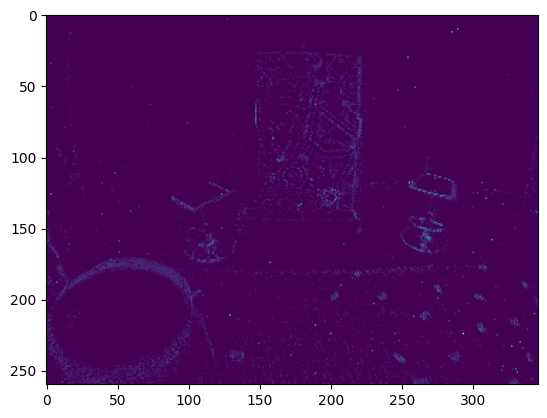

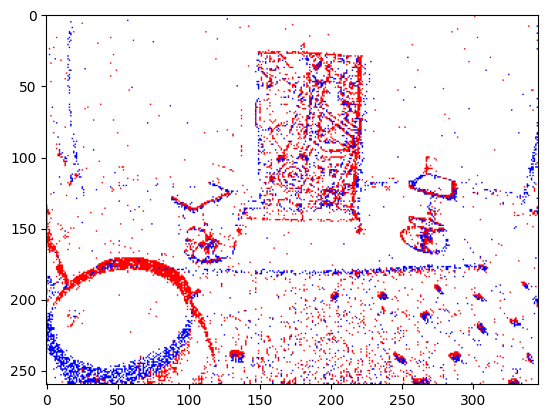

Heatmap at frame: 1


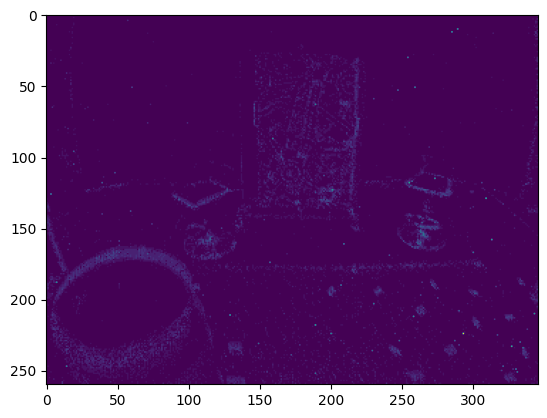

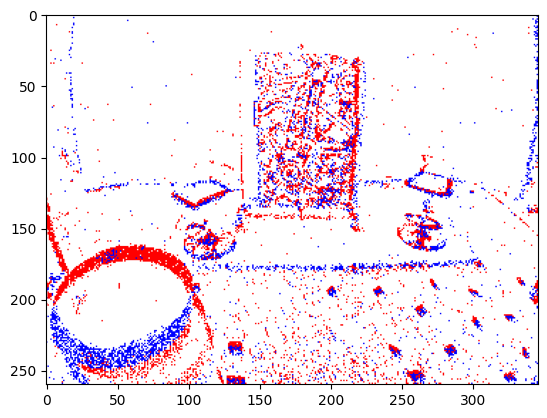

Heatmap at frame: 2


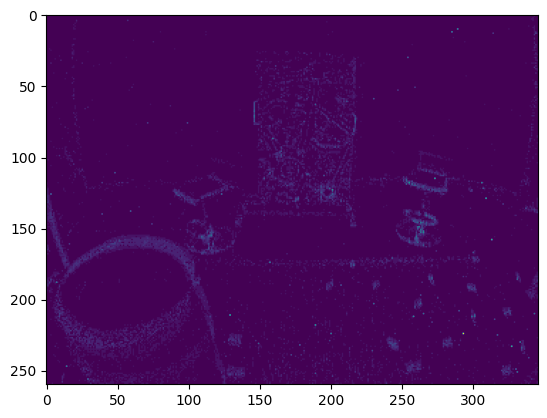

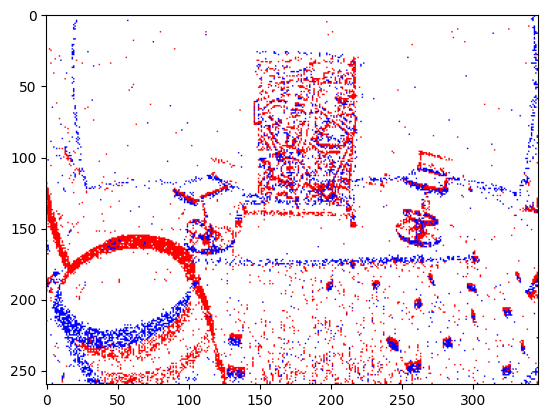

Heatmap at frame: 3


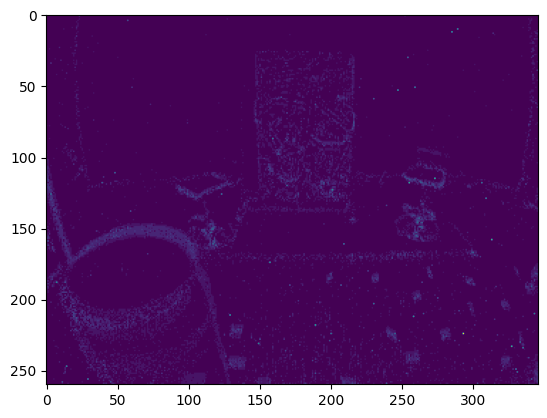

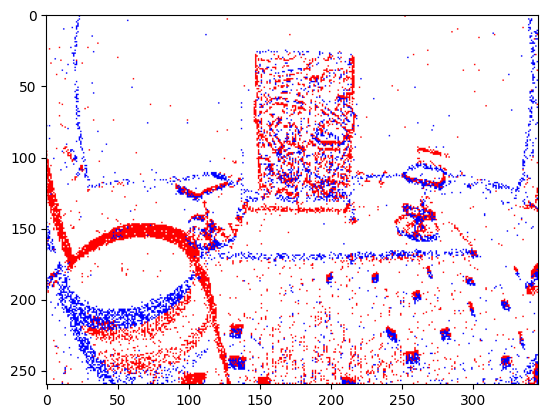

Heatmap at frame: 4


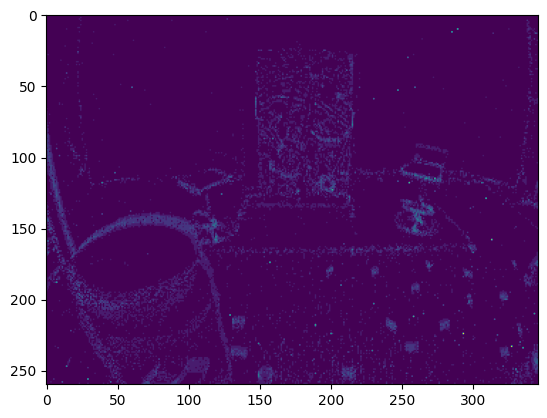

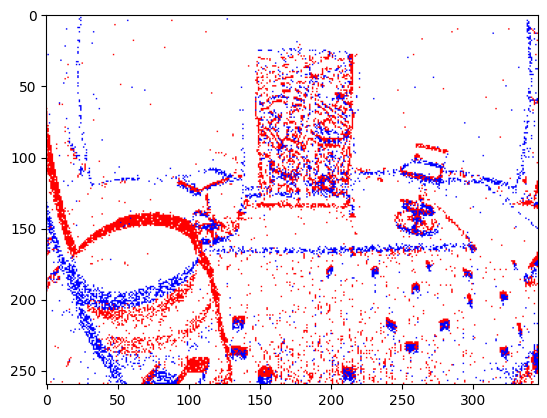

In [9]:
# ===================== Code task here ===================== #
num_splits = 5
events_data = np.zeros((2, 260, 346, num_splits))
slice_size = events.shape[0] // num_splits

for i in range(num_splits):
    events_slice = events[slice_size * i : slice_size * (i + 1), :]
    events_data[..., i] = convert_events_to_image(
        events=events_slice, image_size=(260, 346)
    )
    print("Heatmap at frame:", i)
    events_image = visualize_events_heatmap(
        events_image=events_data[..., i], polarity="both"
    )
    events_rgb = visualize_events_image_rgb(
        events_image=events_data[..., i], polarity="both"
    )
# ========================================================== #

### Questions

> **Note**: Extend the chosen sequence to 1 s, you will be comparing the images you got for a slice of 0.2 s, and the same slice extended to 1.0 s. Answer all questions below in your report for each case (0.2 s and 1.0 s):

1. How clear is the obtained events image? Why? (Explain by showing your resulting images, and analyzing the motion of your chosen sequence).
2. How do the images change after applying the frame-based approach? Why? (Explain by showing your resulting images, and analyzing the motion of your chosen sequence).

One answer only for both cases:
1. For the same time duration, how would the clarity of the events image change if we increase the camera velocity for the same scene? Explain.
2. Which event representation do you find most informative? The one-image, or frame-based approach? Why?
3. In this lab, we only used event counts as encoding. Though this might seem a good idea, some information remains lost. Pinpoint which information is lost with such an encoding scheme and suggest alternatives.